# Import Library

In [109]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir("../input"))

['digit-recognizer']


In [110]:
train_data = pd.read_csv("../input/digit-recognizer/train.csv")
test_data = pd.read_csv("../input/digit-recognizer/test.csv")

In [111]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


both train and test data consist of 784 pixel of image. but of course in the training data we found label column which we won't found in the test data

# Exploratory Data Analysis

In [113]:
train_data.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [114]:
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Both train and test data doesn't have null values.

Now we will trying to see the image from that 784 pixel

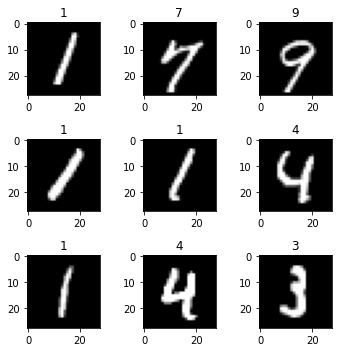

In [165]:
def show_image(pixel, label, index):
    image2d = pixel.values.reshape(28,28)
    plt.subplot('33%d' % (index))
    plt.imshow(image2d, cmap=plt.cm.gray)
    plt.title(label)

plt.figure(figsize=(5,5))
sample_image = train_data.sample(9).reset_index(drop=True)

for index, image in sample_image.iterrows():
    label = image['label']
    pixel = image.drop('label')
    show_image(pixel, label, index)
    
plt.tight_layout()

Total all train data = 42000 
Total all test data = 28000 
Total data train in class 0 = 4132
Total data train in class 1 = 4684
Total data train in class 2 = 4177
Total data train in class 3 = 4351
Total data train in class 4 = 4072
Total data train in class 5 = 3795
Total data train in class 6 = 4137
Total data train in class 7 = 4401
Total data train in class 8 = 4063
Total data train in class 9 = 4188


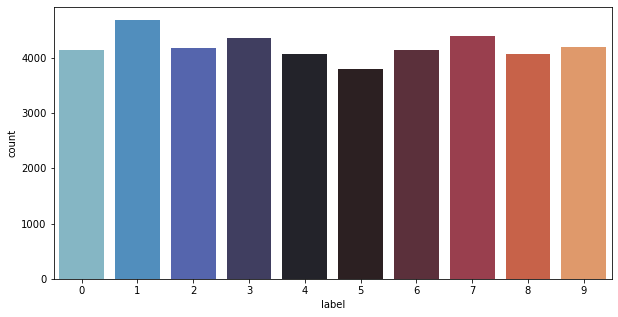

In [116]:
print("Total all train data = %d " % len(train_data))
print("Total all test data = %d " % len(test_data), end='\n============================\n')

labels = train_data.sort_values('label', ascending=True).label.unique()

for i in labels:
    print('Total data train in class %d = %d' % (i, len(train_data[train_data['label'] == i])))

plt.figure(figsize=(10,5))
sns.countplot(train_data['label'], palette='icefire')
plt.show()

In [117]:
train_data.drop(columns=['label']).to_numpy().max()

255

# Preprocessing
### Split data test and train

In [118]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['label']).values.reshape(train_data.shape[0], 28, 28, 1)
y = to_categorical(train_data['label'], num_classes=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Data Agumentation

In [127]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    zoom_range=0.1,
#     shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(
#     rotation_range=20,
#     rescale=1./255,
#     zoom_range=0.2,
# #     shear_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1
# )

train_datagen.fit(X_train)
train_datagen.fit(X_test)

train_gen = train_datagen.flow(X_train, y_train, batch_size=32)
val_gen = val_datagen.flow(X_test, y_test)

# Modelling
### Build CNN Model

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# model = Sequential([
#     Conv2D(32, kernel_size=5, padding='Same', activation='relu', input_shape=(28,28,1)),
#     Conv2D(32, kernel_size=5, padding='Same', activation='relu'),
#     MaxPooling2D(2,2),
#     Dropout(0.25),
    
#     Conv2D(64, kernel_size=3, padding='Same', activation='relu'),
#     Conv2D(64, kernel_size=3, padding='Same', activation='relu'),
#     MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#     Dropout(0.25),
    
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(10, activation='softmax')
# ])

model = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(10, activation='softmax')
])

### Compile Model

In [129]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
#     optimizer=tf.optimizers.Adam(),
    metrics=['accuracy'])

### Callback

In [122]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# callbacks = [
#     EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10),
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

### Fit Model

In [130]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // 32,
    validation_data=val_gen,
    validation_steps=len(X_test) // 32,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
1179/1181 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8830
Epoch 00001: val_loss did not improve from 0.03670
1181/1181 [==============================] - 14s 12ms/step - loss: 0.3772 - accuracy: 0.8831 - val_loss: 0.0843 - val_accuracy: 0.9788
Epoch 2/100
1177/1181 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9500
Epoch 00002: val_loss did not improve from 0.03670
1181/1181 [==============================] - 15s 13ms/step - loss: 0.1704 - accuracy: 0.9500 - val_loss: 0.0677 - val_accuracy: 0.9823
Epoch 3/100
1181/1181 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9617
Epoch 00003: val_loss did not improve from 0.03670
1181/1181 [==============================] - 14s 11ms/step - loss: 0.1275 - accuracy: 0.9617 - val_loss: 0.0551 - val_accuracy: 0.9826
Epoch 4/100
1180/1181 [============================>.] - ETA: 0s - loss: 0.1079 - accuracy: 0.9670
Epoch 00004: val_loss did not improve from 0.0

Epoch 29/100
1178/1181 [============================>.] - ETA: 0s - loss: 0.0359 - accuracy: 0.9889
Epoch 00029: val_loss did not improve from 0.03670
1181/1181 [==============================] - 14s 12ms/step - loss: 0.0358 - accuracy: 0.9890 - val_loss: 0.0378 - val_accuracy: 0.9909
Epoch 30/100
1180/1181 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9887
Epoch 00030: val_loss did not improve from 0.03670
1181/1181 [==============================] - 14s 12ms/step - loss: 0.0367 - accuracy: 0.9887 - val_loss: 0.0373 - val_accuracy: 0.9909
Epoch 31/100
1181/1181 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9886
Epoch 00031: val_loss did not improve from 0.03670
1181/1181 [==============================] - 15s 13ms/step - loss: 0.0380 - accuracy: 0.9886 - val_loss: 0.0376 - val_accuracy: 0.9907
Epoch 32/100
1181/1181 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9888
Epoch 00032: val_loss did not improve from

# Evaluation

In [131]:
train_loss, train_acc = model.evaluate(train_gen, verbose=0)
test_loss, test_acc = model.evaluate(val_gen, verbose=0)
print('Train acc: %.3f%%, Test acc: %.3f%%' % (train_acc*100, test_acc*100))
print('Train loss: %.3f%%, Test loss: %.3f%%' % (train_loss*100, test_loss*100))

Train acc: 98.905%, Test acc: 99.095%
Train loss: 3.621%, Test loss: 3.781%


### Plot Accuracy Loss Model

Total epochs = 36


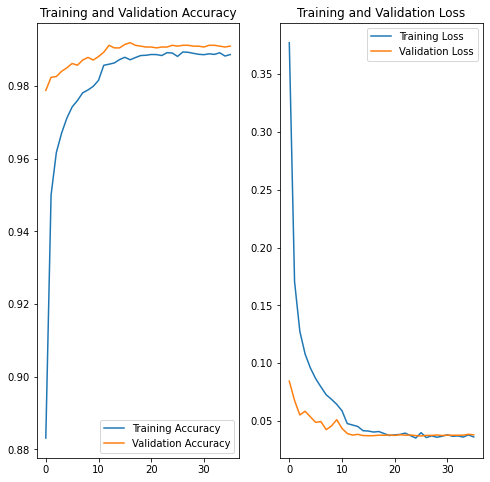

In [132]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,callbacks[0].stopped_epoch+1)
print("Total epochs = {}".format(callbacks[0].stopped_epoch+1))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion Matrix

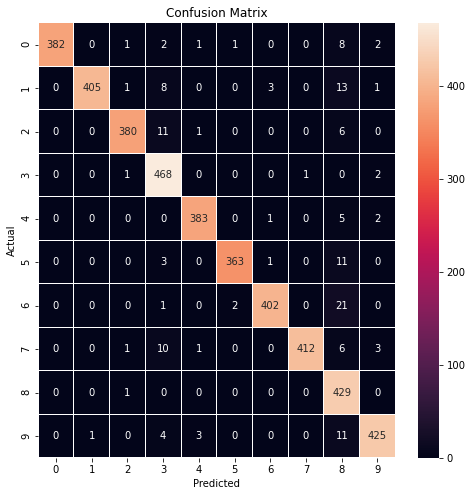

In [133]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=0.01, fmt='0')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

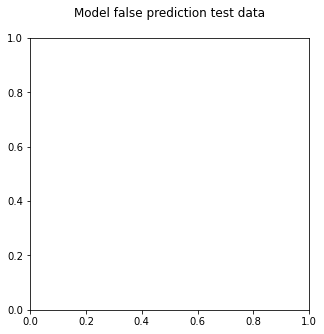

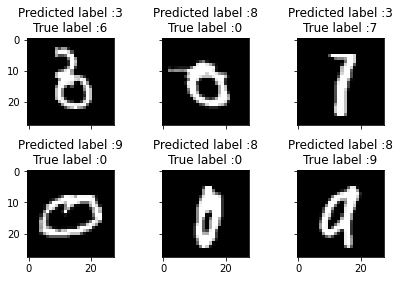

In [172]:
error = (y_pred_class - y_true != 0)
y_pred_class_error = y_pred_class[error]
y_pred_error = y_pred[error]
y_true_error = y_true[error]
X_test_error = X_test[error]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.gray)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
y_pred_error_prob = np.max(y_pred_error, axis=1)
true_prob_error = np.diagonal(np.take(y_pred_error, y_true_error, axis=1))
delta_pred_error = y_pred_error_prob - true_prob_error
sorted_delta_error = np.argsort(delta_pred_error)
most_important_error = sorted_delta_error[-6:]

plt.figure(figsize=(5,5))
display_errors(most_important_error, X_test_error, y_pred_class_error, y_true_error)
plt.tight_layout()

# Predict Unseen Data

In [160]:
# predict result
test_processed = test_data.values.reshape(test_data.shape[0],28,28,1).astype("float32") / 255
results = model.predict(test_processed)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

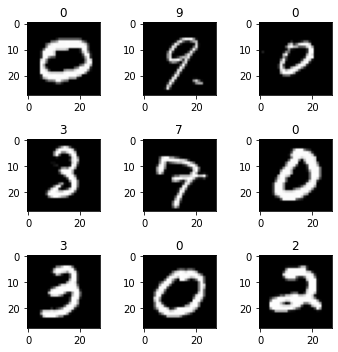

In [170]:
plt.figure(figsize=(5, 5))

sample_test = test_data.head(9)
for index, image_pixels in sample_test.iterrows():
    label = results[index]
    show_image(image_pixels, label, index)
plt.tight_layout()

In [171]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("digit_output.csv",index=False)